In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read Data

In [57]:
def read_data(file_path):
    '''Read Excel File'''
    
    df = pd.read_excel(file_path, engine = 'openpyxl')

    return df

### Prep data for time per question analysis

In [58]:
def prep_time_per_task(df):
    '''Extract time relevant data for each student per question and create new df'''
    
    task_time_df = (
    df.groupby(['candidate_id', 'question_number'], as_index=False)
      .first() 
      [['candidate_id', 'question_number', 'question_title', 'question_duration_seconds', 
        'incident_time_mins', 'auto_score_per_question', 'max_question_score']]
      .copy()
    )
		
    return task_time_df

### convert time student spent on question from seconds to minutes

In [59]:
def convert_seconds_to_minutes(df):
    df['actual_time_per_questions_mins'] = round(df['question_duration_seconds']/60, 2)
    return df

### Calculate ideal time per question using proportional time allocation based on weighted scores

In [60]:
def calculate_ideal_time_per_task(df):
    df['expected_time_spent (mins)'] = round(240 * df['max_question_score'] / 100, 2)
    return df

### Calculate statistics

In [61]:
def calculate_stats(df):
    # Ideal time comparison
    df['over_ideal_time'] = df['actual_time_per_questions_mins'] - df['expected_time_spent (mins)'].median()
    # df['pct_of_ideal_time'] = df['actual_time_per_questions_mins'] / df['expected_time_spent (mins)'] * 100

    # Score as percentage
    # df['pct_score'] = df['auto_score_per_question'] / df['max_question_score'] * 100

    return df


### Visualize and plot data

In [62]:

def plot_expected_vs_actual(df):
    """ Melt a dataframe from wide to long data and plot a grouped barplot of expected vs actual time per question. """

    grouped_df = df.groupby('question_number').agg({
    'expected_time_spent (mins)': 'first',
    'actual_time_per_questions_mins': 'mean',
    'auto_score_per_question' : 'mean'
    }).reset_index()

    # Melt the dataframe
    melted = pd.melt(
        grouped_df,
        id_vars='question_number',
        value_vars=['expected_time_spent (mins)', 'actual_time_per_questions_mins'],
        var_name='Time Type',
        value_name='Minutes'
    )

    # define own colors
    colors = ['#6ca6c3', '#82172b']
    
    # Plot
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=melted,
        x='question_number',
        y='Minutes',
        hue='Time Type',
        palette= colors
    )
    plt.xlabel('Question Number')
    plt.ylabel('Time (mins)')
    plt.title('Actual Avg Time vs. Expected Time Spent per Question')
    plt.legend(title='')
    plt.tight_layout()
    plt.show()

In [63]:
def plot_over_under_ideal_time(df):
    
    df.sort_values('over_ideal_time', ascending=False, inplace=True)

    plt.figure(figsize=(12,6))
    sns.barplot(
    data=df,
    x='question_number',
    y='over_ideal_time',
    hue='question_number',
    palette='RdBu',
    legend=False,
    errorbar=None
    )

    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Question Number')
    plt.ylabel('Minutes Over/Under Ideal')
    plt.title('Time Over/Under Ideal per Question')
    plt.tight_layout()
    plt.show()


### Function to Run the Program

In [64]:
def run_analysis(file_path):

    # Read Data
    df = read_data(file_path)

    # prep and extract data from original df for time per task analysis
    task_time_df = prep_time_per_task(df)

    # convert time taken per task from second to minutes
    task_time_df = convert_seconds_to_minutes(task_time_df)

    # calculate ideal time 
    task_time_df = calculate_ideal_time_per_task(task_time_df)

    task_time_df = calculate_stats(task_time_df)

    return task_time_df


### Export the Processed Analysis File

In [65]:
def export_data(df, output_path, file_format='xlsx'):
    """
    Save cleaned data to file 
    Args:
        df (pandas.DataFrame): Cleaned DataFrame
        output_path (str): Path to save the file
        file_format (str): Format to save ('xlsx', 'csv', 'json')
    """
    try:
        if file_format == 'xlsx':
            df.to_excel(output_path, index=False)
        elif file_format == 'csv':
            df.to_csv(output_path, index=False)
        elif file_format == 'json':
            df.to_json(output_path, orient='records', indent=2)
        else:
            raise ValueError(f"Unsupported format: {file_format}")
        
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

In [66]:
# correlation = task_time_df[['actual_time_per_questions_mins', 'auto_score_per_question']].corr().iloc[0,1]
# print(f"Correlation between time spent and score (all rows): {correlation:.2f}")

### Execute Analysis

In [67]:
task_time_df = run_analysis("data/cleaned_data.xlsx")

In [68]:
export_data(task_time_df, 'processed data/Time_Per_Question_Analysis_2024.xlsx', 'xlsx')

Error saving data: [Errno 13] Permission denied: 'processed data/Time_Per_Question_Analysis_2024.xlsx'


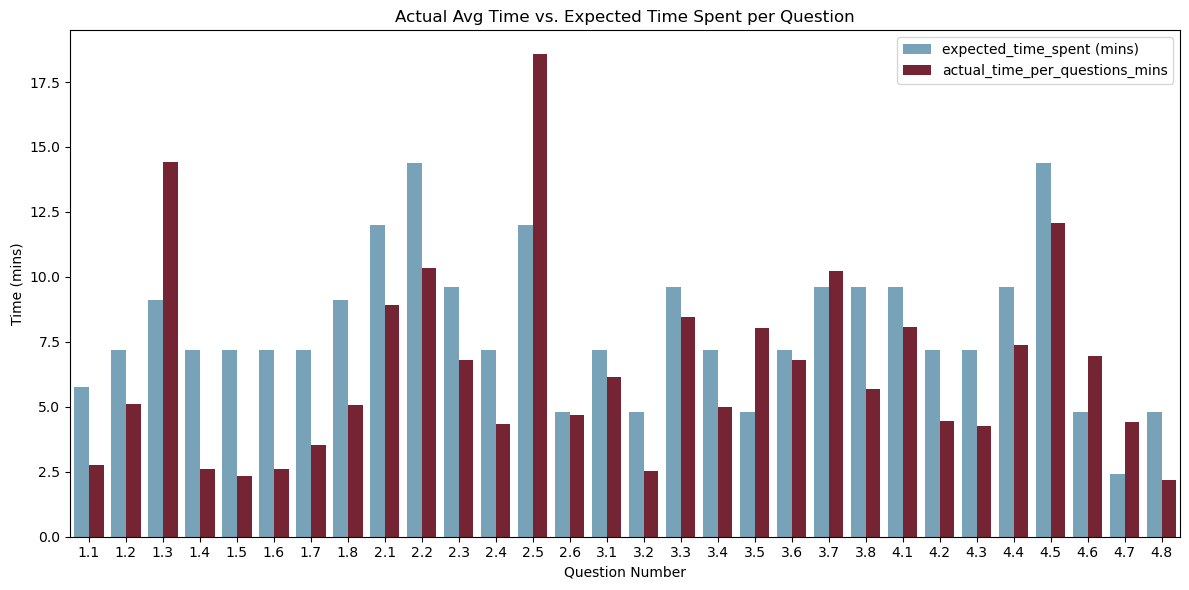

In [69]:
plot_expected_vs_actual(task_time_df)

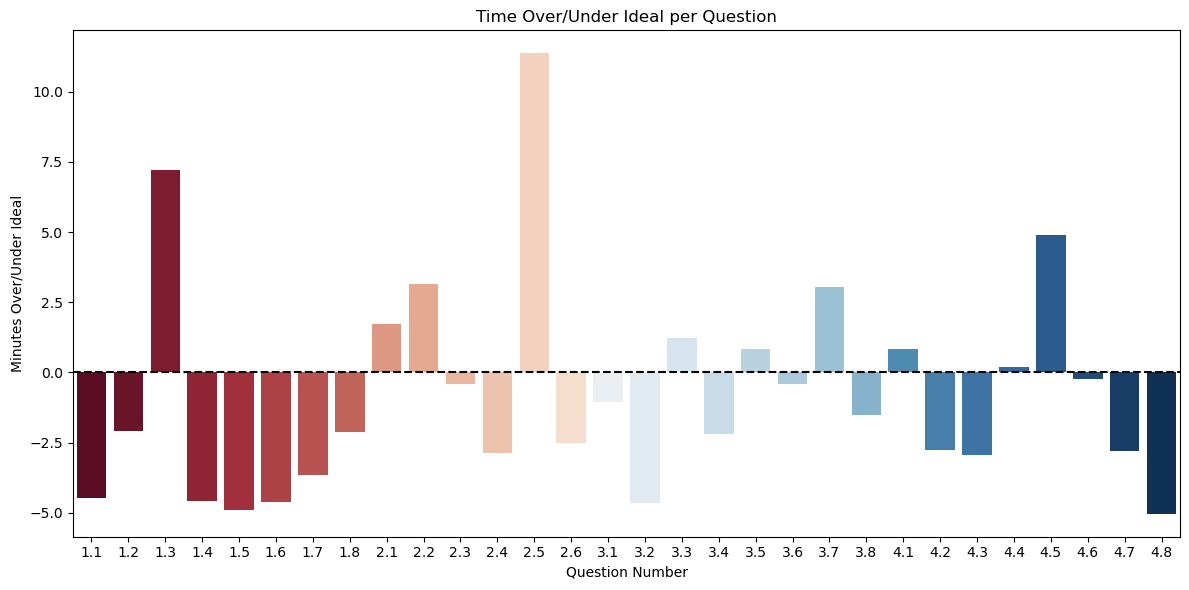

In [70]:
plot_over_under_ideal_time(task_time_df)

In [71]:
# Assuming 'question_id' identifies each question
question_stats = task_time_df.groupby('question_number').agg({
    'actual_time_per_questions_mins': ['mean', 'std', 'median'],
    'expected_time_spent (mins)': 'first'  # expected time is same for all students per question
})
question_stats.columns = ['mean_actual', 'std_actual', 'median_actual', 'expected']


In [72]:
question_stats

,mean_actual,std_actual,median_actual,expected
question_number,,,,
1.1,2.747206,2.213643,2.18,5.76
1.2,5.117329,3.684011,4.08,7.20
1.3,14.424569,9.591685,12.37,9.12
1.4,2.616151,1.599117,2.20,7.20
1.5,2.320650,1.740229,1.82,7.20
1.6,2.598717,1.669852,2.20,7.20
1.7,3.536397,2.387499,2.85,7.20
1.8,5.077715,3.860960,3.97,9.12
2.1,8.929227,7.016564,6.67,12.00
